In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import preprocess
from sklearn.model_selection import train_test_split
import scipy.io as sio
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# Load Data

In [2]:
%%time
rootdir = '../../data.nosync/'
interictal_count = preprocess.count_interictal_files(rootdir)
interictal_files = preprocess.get_interictal_files(rootdir, interictal_count)
preictal_files = preprocess.get_preictal_files(rootdir)
print('Interictal file count:', len(interictal_files))
print('Preictal file count:', len(preictal_files))

Interictal file count: 480
Preictal file count: 24
CPU times: user 3.14 ms, sys: 6.45 ms, total: 9.59 ms
Wall time: 9.5 ms


In [3]:
interictal_y = np.zeros(len(interictal_files))
preictal_y = np.ones(len(preictal_files))
y = np.concatenate((interictal_y, preictal_y), axis=0)
y.shape

(504,)

In [4]:
%%time
X_list = []
X_list.extend(interictal_files)
X_list.extend(preictal_files)
len(X_list)

CPU times: user 26 µs, sys: 3 µs, total: 29 µs
Wall time: 31.9 µs


504

In [5]:
X = np.array(X_list)
print(type(X))
X.shape

<class 'numpy.ndarray'>


(504,)

# Preprocess

In [6]:
def rescale_ch(signal):
    signal = signal.reshape((len(signal), 1))
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler = scaler.fit(signal)
    rescaled = scaler.transform(signal)
    rescaled = rescaled.reshape((-1,))
    return rescaled

In [7]:
filepath = rootdir + X[0]
mat = sio.loadmat(filepath)
sigbuf = preprocess.get_sig(mat)
rescaled_sigbuf = np.empty_like(sigbuf)

# normalise channels
for j in tqdm(range(sigbuf.shape[0])):
    rescaled_sigbuf[j,:] = rescale_ch(sigbuf[j,:])

100%|██████████| 16/16 [00:00<00:00, 136.57it/s]


In [8]:
# rescale signal in range [0,1]
X_sig = np.zeros((504, 16, 239766))

for i in tqdm(range(len(X))):
    filepath = rootdir + X[i]
    mat = sio.loadmat(filepath)
    sigbuf = preprocess.get_sig(mat)
    rescaled_sigbuf = np.empty_like(sigbuf)
    for j in range(sigbuf.shape[0]):
        rescaled_sigbuf[j,:] = rescale_ch(sigbuf[j,:])
    X_sig[i] = rescaled_sigbuf

100%|██████████| 504/504 [01:13<00:00,  6.85it/s]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_sig, y, test_size=0.33, random_state=42)
print(X_train.shape)
print(X_test.shape)

(337, 16, 239766)
(167, 16, 239766)


# Build Model

Architecture is a fully convolutional neural network according to [Wang, 2016](https://arxiv.org/abs/1611.06455).

In [12]:
num_classes = 2

In [13]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    
    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    
    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    
    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    
    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)
    
    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=X_train.shape[1:])

# Build Model

In [16]:
epochs = 200
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/200
9/9 [==============================] - 94s 9s/step - loss: 0.0424 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.3086 - val_sparse_categorical_accuracy: 0.9412
Epoch 2/200
9/9 [==============================] - 79s 9s/step - loss: 0.0927 - sparse_categorical_accuracy: 0.9822 - val_loss: 0.2651 - val_sparse_categorical_accuracy: 0.9412
Epoch 3/200
9/9 [==============================] - 67s 7s/step - loss: 0.0305 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2391 - val_sparse_categorical_accuracy: 0.9412
Epoch 4/200
9/9 [==============================] - 61s 7s/step - loss: 0.0211 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2265 - val_sparse_categorical_accuracy: 0.9412
Epoch 5/200
9/9 [==============================] - 60s 7s/step - loss: 0.0133 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.2239 - val_sparse_categorical_accuracy: 0.9412
Epoch 6/200
9/9 [==============================] - 60s 7s/step - loss: 0.0074 - sparse_categorical_accuracy: 1.0000

Epoch 47/200
9/9 [==============================] - 62s 7s/step - loss: 4.7652e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5530 - val_sparse_categorical_accuracy: 0.9412
Epoch 48/200
9/9 [==============================] - 61s 7s/step - loss: 5.3531e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5529 - val_sparse_categorical_accuracy: 0.9412
Epoch 49/200
9/9 [==============================] - 61s 7s/step - loss: 4.6506e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5528 - val_sparse_categorical_accuracy: 0.9412
Epoch 50/200
9/9 [==============================] - 61s 7s/step - loss: 5.3779e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5526 - val_sparse_categorical_accuracy: 0.9412
Epoch 51/200
9/9 [==============================] - 60s 7s/step - loss: 6.7241e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.5524 - val_sparse_categorical_accuracy: 0.9412
Epoch 52/200
9/9 [==============================] - 60s 7s/step - loss: 5.9464e-04 - spars

# Evaluate Model

In [19]:
model = keras.models.load_model("best_model.h5")
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

6/6 [==============================] - 12s 896ms/step - loss: 0.2270 - sparse_categorical_accuracy: 0.9401
Test accuracy: 0.940119743347168
Test loss: 0.22699715197086334


# Plot Loss

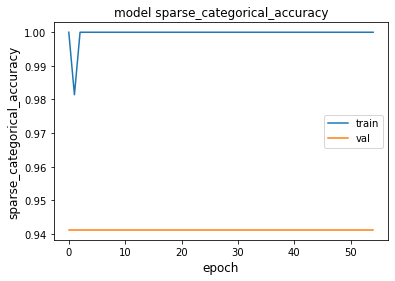

In [20]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")